In [1]:
!pip install foolbox

     |████████████████████████████████| 1.7 MB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 188 kB 43.5 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 5.2 MB/s  eta 0:00:01


In [7]:
import foolbox as fb
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transform),
    batch_size=1000, shuffle=False)


# Instantiate the model, define the loss and the optimizer
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Test the model
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Train and test the model
for epoch in range(1, 3):
    train(epoch)
    test()

# Get a batch of images and labels from the test_loader
images, labels = next(iter(test_loader))
images = images * 0.3081 + 0.1307
print(images.min(), images.max())

# Generate adversarial example
fmodel = fb.models.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.FGSM()
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

_, advs, success = attack(fmodel, images, labels, epsilons=epsilons)



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.350855
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.729406
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.528356
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.470838
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.501242
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.434426
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.418050
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.423626
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.313954
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.104373

Test set: Average loss: 0.0001, Accuracy: 9694/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.149281
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.234822
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.396426
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.483084
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.187061
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.254686
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.457753
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.131371
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.183242
T

In [9]:
success

tensor([[False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False,  True],
        [False,  True, False,  ..., False,  True,  True],
        ...,
        [ True,  True, False,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True]])

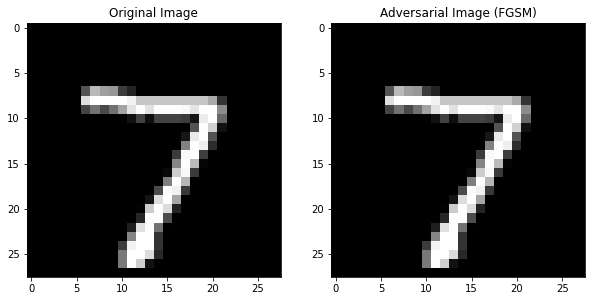

In [11]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the test_loader
images, labels = next(iter(test_loader))

# Undo the normalization
images = images * 0.3081 + 0.1307

# Generate FGSM attack
fgsm_attack = fb.attacks.FGSM()
_, advs_fgsm, success_fgsm = fgsm_attack(fmodel, images, labels, epsilons=epsilons)

# Select one image and one adversarial example from the batch
image = images[0]
adv_image = advs_fgsm[0][0]  # first epsilon, first image in the batch

# Plot the original and adversarial images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().detach().numpy(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(adv_image.squeeze().detach().numpy(), cmap='gray')
plt.title('Adversarial Image (FGSM)')

plt.show()

In [16]:
from sewar import full_ref
import numpy as np

# Assume image and adv_image are the original and adversarial images
# Convert them to numpy arrays
image_np = image.squeeze().detach().numpy()
adv_image_np = adv_image.squeeze().detach().numpy()

# Add a dummy dimension to the images to make them 3D
image_np = image_np[np.newaxis, :, :]
adv_image_np = adv_image_np[np.newaxis, :, :]

# PSNR
psnr = full_ref.psnr(image_np, adv_image_np, MAX=1)

# ERGAS
ergas = full_ref.ergas(image_np, adv_image_np, r=1)

# SSIM
ssim = full_ref.ssim(image_np, adv_image_np, MAX=1, mode='same')[0]

# SAM
sam = full_ref.sam(image_np, adv_image_np)

print("PSNR:", psnr)
print("ERGAS:", ergas)
print("SSIM:", ssim)
print("SAM:", sam)




PSNR: inf
ERGAS: nan
SSIM: 1.0
SAM: nan


/Users/rakeshpodder/opt/anaconda3/lib/python3.9/site-packages/sewar/full_ref.py:264: RuntimeWarning: invalid value encountered in double_scalars
  val = np.clip(np.dot(GT[:,i],P[:,i]) / (np.linalg.norm(GT[:,i])*np.linalg.norm(P[:,i])),-1,1)
